<a href="https://colab.research.google.com/github/linesn/reddit_analysis/blob/main/Notebooks/Reddit_relational_net_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 5 Homework - Extracting a relational network from Reddit data
Nick Lines

## Imports and environment set up

In [1]:
%pylab inline
import re
import os
import pandas as pd
import scipy.sparse as sp
import networkx as nx
from itertools import chain

Populating the interactive namespace from numpy and matplotlib


In [2]:
try:
  import datashader as ds
  import datashader.transfer_functions as tf
  from datashader.layout import random_layout, circular_layout, forceatlas2_layout
  from datashader.bundling import connect_edges, hammer_bundle
except:
  %pip install datashader
  import datashader as ds
  import datashader.transfer_functions as tf
  from datashader.layout import random_layout, circular_layout, forceatlas2_layout
  from datashader.bundling import connect_edges, hammer_bundle

     |████████████████████████████████| 15.8MB 319kB/s 
     |████████████████████████████████| 81kB 9.6MB/s 
     |████████████████████████████████| 686kB 39.5MB/s 
     |████████████████████████████████| 112kB 47.6MB/s 
  Created wheel for datashape: filename=datashape-0.5.2-cp37-none-any.whl size=59430 sha256=45e004cae99efb9642daf4dba270b2fac0895b8efe2f4247f2d813ba387bcb9c
  Stored in directory: /root/.cache/pip/wheels/8d/06/05/c1cba3d57bdcfd3960e3f60a9fdc97e4baef2ef09af0ad1ef8
Successfully built datashape
ERROR: distributed 2021.4.0 has requirement cloudpickle>=1.5.0, but you'll have cloudpickle 1.3.0 which is incompatible.
ERROR: distributed 2021.4.0 has requirement dask>=2021.03.0, but you'll have dask 2.12.0 which is incompatible.
  Found existing installation: distributed 1.25.3
    Uninstalling distributed-1.25.3:
      Successfully uninstalled distributed-1.25.3


This cell defines system-dependent configuration such as those different in Linux vs. Windows

In [3]:
if 'COLAB_GPU' in os.environ: # a hacky way of determining if you are in colab.
  print("Notebook is running in colab")
  from google.colab import drive
  drive.mount("/content/drive")
  DATA_DIR = "./drive/My Drive/Data/"
  
else:
  # Get the system information from the OS
  PLATFORM_SYSTEM = platform.system()

  # Darwin is macOS
  if PLATFORM_SYSTEM == "Darwin":
      EXECUTABLE_PATH = Path("../dependencies/chromedriver")
  elif PLATFORM_SYSTEM == "Windows":
      EXECUTABLE_PATH = Path("../dependencies/chromedriver.exe")
  else:
      logging.critical("Chromedriver not found or Chromedriver is outdated...")
      exit()
  DATA_DIR = "../Data/raw/"

Notebook is running in colab
Mounted at /content/drive


## Data extraction

In [4]:
comment_df = pd.read_csv(DATA_DIR + "raw/Reddit/REDDIT_COMMENTS_2021-02-03T17-02-00-0500.csv")
post_df = pd.read_csv(DATA_DIR + "raw/Reddit/REDDIT_POSTS_2021-02-03T16-56-30-0500.csv")

In [5]:
comment_posts = set(comment_df.post_id.unique())

In [6]:
posts = set(post_df.post_id.unique())

In [7]:
print(f"There are {len(comment_posts.intersection(posts))} posts with comments on them in the data")

There are 833 posts with comments on them in the data


We'll now make two networkks. The first is a post-author bipartite graph pairing each post to the list of agents. The second is a comment-author-post network that pairs agents with the posts they comment on. We'll need to make indices that track which agent and which post get assigned which integer index.

In [8]:
agents = array(list(set(comment_df.comment_author).union(set(post_df.post_author))))
print(f"There are {agents.shape[0]} agents in the network.")
all_posts = array(list(posts.union(comment_posts)))
print(f"There are {all_posts.shape[0]} posts in the network.")

There are 6787 agents in the network.
There are 1095 posts in the network.


In [9]:
post_author_net = nx.from_edgelist(post_df[["post_id", "post_author"]].values)

In [10]:
commenter_post_net = nx.from_edgelist(comment_df[["comment_author", "post_id"]].values)

In [11]:
post_author_net.add_nodes_from(commenter_post_net)
commenter_post_net.add_nodes_from(post_author_net)
#X = nx.adjacency_matrix(post_author_net)
#Y = nx.adjacency_matrix(commenter_post_net)
Xprime = nx.Graph()
Xprime.add_nodes_from(sorted(post_author_net.nodes(data=True)))
Xprime.add_edges_from(post_author_net.edges(data=True))
Yprime = nx.Graph()
Yprime.add_nodes_from(sorted(commenter_post_net.nodes(data=True)))
Yprime.add_edges_from(commenter_post_net.edges(data=True))
X = nx.adjacency_matrix(Xprime)
Y = nx.adjacency_matrix(Yprime)

In [13]:
len(list(post_author_net.nodes))

7882

In [14]:
print(list(Xprime.nodes)==list(Yprime.nodes))

True


Because it is convenient to do so in `networkx`, we will include both the agents and the post id's in the nodes lists (even though that is less interpretable). We've created two matrices, `X` and `Y`, which respectively represent the agents that commented on each post, and the posts that were authored by each agent. Multiplying these to get `Z` we have now an adjacency matrix representing the connections between agents, starting at commenters and ending at post authors. This is what I am most interested in: seeing which agents are connected in Reddit political discussions.

In [15]:
X.shape

(7882, 7882)

In [16]:
Y.shape

(7882, 7882)

In [17]:
Z = X*Y

In [18]:
commenter_author_net = nx.from_scipy_sparse_matrix(Z)

In [19]:
commenter_author_net = nx.relabel.relabel_nodes(commenter_author_net, Xprime.nodes)

In [20]:
m = nx.adjacency_matrix(commenter_author_net)

In [21]:
mm = m.todense()

In [22]:
pd.DataFrame(mm).to_csv(DATA_DIR+"/adjacency.csv", header=None, index=None)

In [23]:
def hasNumbers(inputString):
  return bool(re.search(r'\d', inputString))

In [25]:
numbers = [1 if hasNumbers(i) else 0 for i in Xprime.nodes()]
pure_text = [1 if i.isalpha() else 0 for i in Xprime.nodes()]

In [26]:
actors_df = pd.DataFrame({"actors":Xprime.nodes(), "numbers":numbers, "pure_text":pure_text})

In [27]:
actors_df.to_csv(DATA_DIR+"/actors.csv", index=None)

In [28]:
mm.shape

(7882, 7882)

## Visualization

To visualize our networks we will use the `networkx` and `datashader` libraries, following the documentation available at [https://datashader.org/user_guide/Networks.html](https://datashader.org/user_guide/Networks.html). 

In [29]:
cvsopts = dict(plot_height=400, plot_width=400)


def nodesplot(nodes, name=None, canvas=None, cat=None):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    aggregator=None if cat is None else ds.count_cat(cat)
    agg=canvas.points(nodes,'x','y',aggregator)
    return tf.spread(tf.shade(agg, cmap=["#FF3333"]), px=3, name=name)


def edgesplot(edges, name=None, canvas=None):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    return tf.shade(canvas.line(edges, 'x','y', agg=ds.count()), name=name)


def graphplot(nodes, edges, name="", canvas=None, cat=None):
    if canvas is None:
        xr = nodes.x.min(), nodes.x.max()
        yr = nodes.y.min(), nodes.y.max()
        canvas = ds.Canvas(x_range=xr, y_range=yr, **cvsopts)
        
    np = nodesplot(nodes, name + " nodes", canvas, cat)
    ep = edgesplot(edges, name + " edges", canvas)
    return tf.stack(ep, np, how="over", name=name)


def ng(graph,name):
    graph.name = name
    return graph


def nx_layout(graph):
    layout = nx.circular_layout(graph)
    #layout = nx.fruchterman_reingold_layout(graph)
    data = [[node]+layout[node].tolist() for node in graph.nodes]

    nodes = pd.DataFrame(data, columns=['id', 'x', 'y'])
    nodes.set_index('id', inplace=True)

    edges = pd.DataFrame(list(graph.edges), columns=['source', 'target'])
    return nodes, edges


def nx_plot(graph, name=""):
    print(graph.name, len(graph.edges))
    nodes, edges = nx_layout(graph)
    
    direct = connect_edges(nodes, edges)
    bundled_bw005 = hammer_bundle(nodes, edges)
    bundled_bw030 = hammer_bundle(nodes, edges, initial_bandwidth=0.30)

    return [graphplot(nodes, direct,         graph.name),
            graphplot(nodes, bundled_bw005, "Bundled bw=0.05"),
            graphplot(nodes, bundled_bw030, "Bundled bw=0.30")]

Post Author Network 1095
Commenter Post Network 9001
Commenter Author Network 11962


Post Author Network,Bundled bw=0.05,Bundled bw=0.30
Commenter Post Network,Bundled bw=0.05,Bundled bw=0.30
Commenter Author Network,Bundled bw=0.05,Bundled bw=0.30

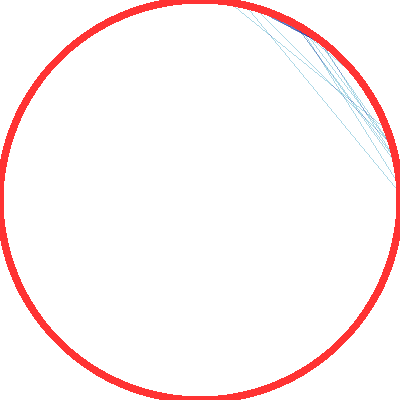
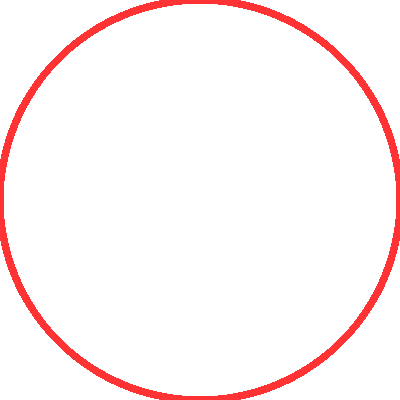
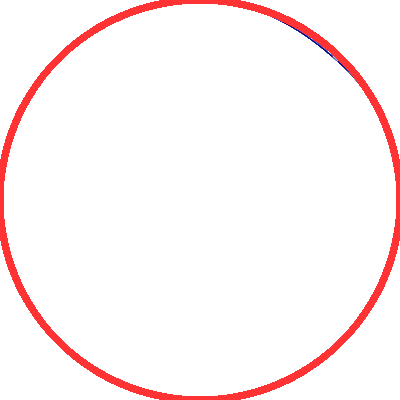
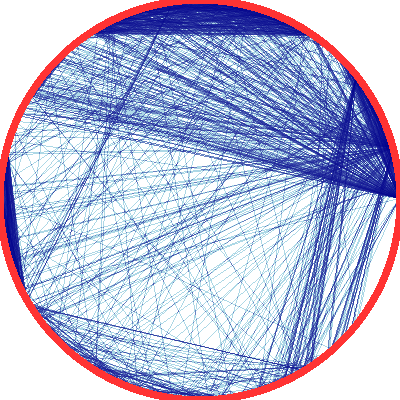
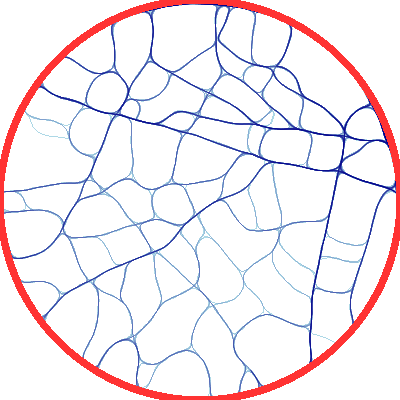
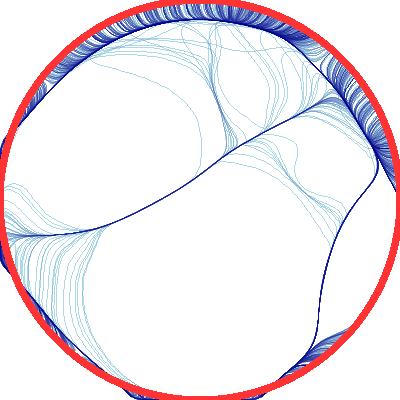
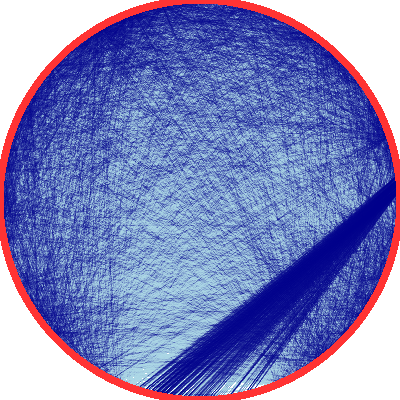
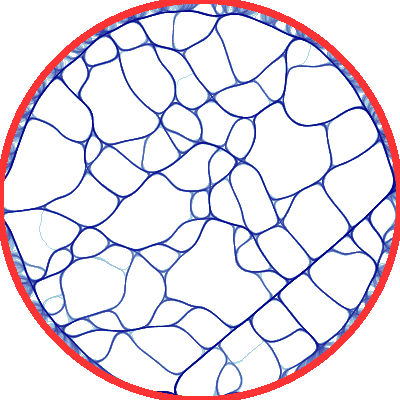
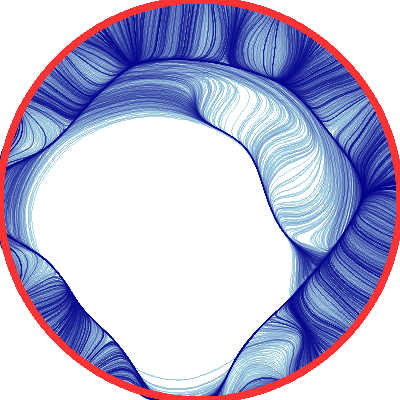

In [30]:
plots = [nx_plot(g) for g in
           [ng(post_author_net,        name="Post Author Network"), 
            ng(commenter_post_net,     name="Commenter Post Network"),
            ng(commenter_author_net,   name="Commenter Author Network")
            ]]

tf.Images(*chain.from_iterable(plots)).cols(3)

These plots are more meaningful for the Commenter Author Network than the other two, but they are still interesting. They show the agents and posts in a circular layout with connections drawn in blue between agents and posts. The leftmost plot in each row shows all direct connections. The remaining columns show the bundled results with two different bundling weights. This means that agents and posts that are similarly connected are bundled together to reduce the number of lines shown and to make community groupings more visible.